In [1]:
import torch
from transformers import AutoModelForSequenceClassification

print("PyTorch 버전:", torch.__version__)
print("is CUDA available:", torch.cuda.is_available())

PyTorch 버전: 1.10.2+cu113
is CUDA available: True


In [2]:
import pandas as pd

In [3]:
review_df = pd.read_csv('./labeled_reviews_lmstudio_cleaned.csv')
review_df.head()

,content,label,model_used
0,^,2,gemma-lmstudio
1,^^\n좋아요~,2,gemma-lmstudio
2,^^,2,gemma-lmstudio
3,^^ 동창모임 고급스럽고 맛있는 코스로 먹었어요!!,2,gemma-lmstudio
4,^^ 맛나용~~,2,gemma-lmstudio


In [7]:
print(review_df.isnull().sum())

content       1
label         0
model_used    0
dtype: int64


In [9]:
review_df = review_df.dropna()
print(review_df.isnull().sum())

content       0
label         0
model_used    0
dtype: int64


In [11]:
import numpy as np

cleaned_review = []

for review in review_df['content']:
  if len(review) < 2:
      review = np.nan
  else:
    if review == '':
      review = np.nan

    review = review.strip()

    if '\n' in review:
      review = review.replace('\n', '')

  cleaned_review.append(review)

review_df['content'] = cleaned_review

In [13]:
# 결측치 확인
print(review_df.isnull().sum())

content       184
label           0
model_used      0
dtype: int64


In [15]:
# 결측치 제거
review_df = review_df.dropna()

# 결측치 확인
print(review_df.isnull().sum())

content       0
label         0
model_used    0
dtype: int64


In [17]:
# 중복치 확인
print("중복 행 개수:", review_df.duplicated().sum())

중복 행 개수: 51


In [19]:
# 중복치 제거
review_df = review_df.drop_duplicates()

# 제거 후 개수
print("중복치 제거 후 행 개수 :", len(review_df))

중복치 제거 후 행 개수 : 368833


In [21]:
# 범주별 데이터 수 차이 확인을 위해 label groupby 집계
review_df.groupby('label').size().reset_index(name='count')

,label,count
0,0,20852
1,1,49428
2,2,298553


In [23]:
sample_size = review_df['label'].value_counts().min()
balanced_df = review_df.groupby('label').sample(n=sample_size, random_state=42)
print("Balanced class counts:\n", balanced_df['label'].value_counts())

Balanced class counts:
 label
0    20852
1    20852
2    20852
Name: count, dtype: int64


In [25]:
# 분리
input_list = balanced_df['content'].tolist()
label_list = balanced_df['label'].tolist()

In [ ]:
balanced_df.groupby('label').size().reset_index(name='count')

In [27]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import torch

In [29]:
# 1. 데이터 준비
df = balanced_df[['content', 'label']].copy()
df.columns = ['text', 'label']  # HuggingFace 형식에 맞게 컬럼명 변경

In [31]:
# 2. train/test 분리 (stratify)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

In [33]:
# 3. 토크나이저 및 전처리
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)

C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--beomi--KcELECTRA-base-v2022. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [35]:
def preprocess(batch):
    return tokenizer(batch['text'], truncation=True, max_length=128)

In [37]:
train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/50044 [00:00<?, ? examples/s]

Map:   0%|          | 0/12512 [00:00<?, ? examples/s]

In [ ]:
from datasets import Value

# 4. 라벨 타입 정수형으로 지정
train_dataset = train_dataset.cast_column("label", Value("int64"))
test_dataset = test_dataset.cast_column("label", Value("int64"))

In [ ]:
# 3. Config 직접 설정 (Dropout 조정)
config = ElectraConfig.from_pretrained(
    model_name,
    num_labels=3,
    hidden_dropout_prob=0.4,               # ✅ hidden layer dropout 확률 조정
    attention_probs_dropout_prob=0.4       # ✅ self-attention dropout 확률 조정
)

In [ ]:
# 4. 모델 생성 (위 config 사용)
model_0624_5 = ElectraForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

In [39]:
# 5. Load the pre-trained model (with classification head for 3 classes)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'c

In [41]:
# 4. 평가지표 함수 정의
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": (preds == labels).mean(),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

In [ ]:
from torch.nn import CrossEntropyLoss

# 클래스별 가중치: (예시) [부정:1.0, 중립:2.0, 긍정:1.0]
class_weights = torch.tensor([1.0, 2.0, 1.0]).to(model_0624_5.device)

# Custom Trainer 정의
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # GPU로 class weight 보내기
        weight = class_weights.to(model.device)
        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [43]:
# 5. Trainer 학습 설정
training_args = TrainingArguments(
    output_dir="./best_model",
    evaluation_strategy="steps",
    eval_steps=500,                 # evaluate every 500 steps
    save_strategy="steps",
    save_steps=500,                 # save checkpoint every 500 steps
    save_total_limit=2,             # keep only the 2 most recent checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    
    num_train_epochs=6,
    per_device_train_batch_size=64,  # use 64 if possible (else reduce to 32)
    per_device_eval_batch_size=64,
    
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,               # ~5% of training steps as warm-up
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,              # log every 100 steps
    
    fp16=True,                      # enable mixed precision for speed
    report_to=[],                   # disable default logging (TensorBoard, etc.)
    seed=42
)

In [45]:
# 8. Initialize Trainer with early stopping callback
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,            # using our test_df as validation set for early stopping
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),  # dynamic padding to longest in batch
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Using cuda_amp half precision backend


In [47]:
# 6. 학습 실행
trainer.train()

The following columns in the training set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\User\anaconda3\envs\deepnlpenv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50044
  Num Epochs = 6
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4692
  Number of trainable parameters = 127779075
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is

Step,Training Loss,Validation Loss,Accuracy,Macro F1
500,0.667700,0.673891,0.725304,0.724577
1000,0.620600,0.660814,0.731138,0.729606
1500,0.628900,0.652223,0.734575,0.731394
2000,0.543500,0.681402,0.730419,0.732368
2500,0.460500,0.719024,0.726982,0.727272
3000,0.451700,0.756609,0.725224,0.720584
3500,0.360600,0.821502,0.722267,0.720430


The following columns in the evaluation set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12512
  Batch size = 64
Saving model checkpoint to ./best_model\checkpoint-500
Configuration saved in ./best_model\checkpoint-500\config.json
Model weights saved in ./best_model\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./best_model\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./best_model\checkpoint-500\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 125

TrainOutput(global_step=3500, training_loss=0.5630141350882394, metrics={'train_runtime': 1038.1374, 'train_samples_per_second': 289.233, 'train_steps_per_second': 4.52, 'total_flos': 1.3623544099180512e+16, 'train_loss': 0.5630141350882394, 'epoch': 4.48})

In [48]:
# 7. 테스트 데이터 예측
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

The following columns in the test set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 12512
  Batch size = 64


In [49]:
# 8. 결과 리포트 출력
print(classification_report(y_true, y_pred, target_names=["부정", "중립", "긍정"]))

              precision    recall  f1-score   support

          부정       0.88      0.73      0.80      4170
          중립       0.65      0.66      0.66      4171
          긍정       0.69      0.80      0.74      4171

    accuracy                           0.73     12512
   macro avg       0.74      0.73      0.73     12512
weighted avg       0.74      0.73      0.73     12512



The following columns in the test set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: text. If text are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 12512
  Batch size = 64


              precision    recall  f1-score   support

          부정       0.88      0.73      0.80      4170
          중립       0.65      0.66      0.66      4171
          긍정       0.69      0.80      0.74      4171

    accuracy                           0.73     12512
   macro avg       0.74      0.73      0.73     12512
weighted avg       0.74      0.73      0.73     12512



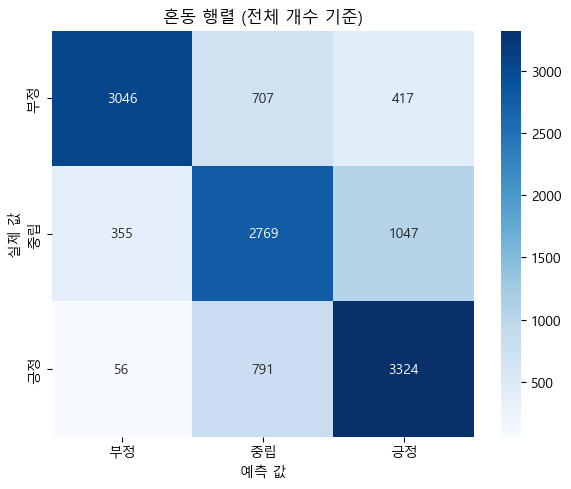

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

# ✅ 1. 예측값
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

# ✅ 2. classification report
print(classification_report(y_true, y_pred, target_names=["부정", "중립", "긍정"]))

# ✅ 3. confusion matrix 시각화 (seaborn + 전체 수 기준)
cm = confusion_matrix(y_true, y_pred)  # normalize=None 상태 유지

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['부정', '중립', '긍정'],
            yticklabels=['부정', '중립', '긍정'])

plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.title('혼동 행렬 (전체 개수 기준)')
plt.tight_layout()
plt.show()


In [53]:
# 9. 모델 저장
trainer.save_model("./kc_electra_sentiment_model_0624_6")

Saving model checkpoint to ./kc_electra_sentiment_model_0624_6
Configuration saved in ./kc_electra_sentiment_model_0624_6\config.json
Model weights saved in ./kc_electra_sentiment_model_0624_6\pytorch_model.bin
tokenizer config file saved in ./kc_electra_sentiment_model_0624_6\tokenizer_config.json
Special tokens file saved in ./kc_electra_sentiment_model_0624_6\special_tokens_map.json


In [63]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. 모델과 토크나이저 로딩
model_path = "./kc_electra_sentiment_model_0624_6"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# 2. GPU/CPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3. 감성 레이블
labels = ['부정', '중립', '긍정']

# 4. 예측 함수
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # ✅ 입력도 GPU로 이동
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
        label_idx = torch.argmax(probs).item()
        return labels[label_idx], float(probs[label_idx])

# 5. 테스트용 리뷰 샘플
sample_reviews = [
    "진짜 맛없고 최악이었어요.",
    "그냥 그랬어요. 무난한 편이에요.",
    "진짜 존맛탱!! 또 올 거예요~",
    "서비스는 별로였지만 음식은 괜찮았어요.",
    "위생 상태가 좀 의심스럽네요.",
    "오래 기다렸지만 맛있어요",
    "파 분명히 빼달라고 요청했는데 고의인지 실수인진 모르겠지만 결국에 넣으셨더라고요 사람 말 좀 제대로 들어주세요 맛은 맛있어요",
    "늦은시간 저녁이라 터미널 앞 김밥천국 24시간 하는곳으로 방문했습니다 메뉴판에 정말 다양한 메뉴들이 있었습니다 테이블도 많고 혼밥하시는 분들을 위한 자리도 많이 있어요 음식도 빨리 나오고 하나 같이 다 먹음직스럽게 생겼어요 여기는 다른지점에 거의 못본 곱배기도 있더라구요 너무 많이 시켜서 라볶이는 좀 남기긴 했지만 잘 먹고 왔어요 여기는 늦은시간에 오시는 손님도 정말 많지만 배달이 정말 많더라구요 음식들이 다 평타이상이라 뭘 시켜도 믿고 먹을수 있을거 같아요",
    "리모델링하고는 처음 가보네요 비슷한데 깔끔해지고 끝이 벽 보게 바뀌었네요 정수기 위치도 바뀌고 주방 위쪽에 일부 메뉴들 써있네요 참치김밥 주문했어요 5천원이에요 이렇게 비싼줄 몰랐네요ㅠ 일반만 3천인가 3500인가 그렇고 나머진 4500부터 시작이네요 김밥만 드실거면 선불이에요 깻잎에 참치 싸져있고 당근 우엉 햄 단무지 계란 들어가요 깻잎이 들어가서 그런가 오이나 시금치는 없네요 겉에 깨 조금 뿌려져있어요 전엔 엄청 맛있었는데 이번엔 그냥 맛있는 정도? 참치 양도 적어진 것 같은 느낌",
    "솔직히 김밥천국은 점바점이 강하잖아요..🥹 어딘 맛있는데 어딘 맛없고..그리고 불친절하거나 위생적이지 못한 곳도 많고해서 방문을 잘안했는데 청주터미널점은 김밥천국중에서도 제일 맛있고 친절하셔서 넘 좋더라고요~💖 그래서 그런가 늦은시간임에도 불구하고 식사하시는 손님들이 엄청 많았는데요, 시킨 메뉴 하나하나 다 맛있어서 놀랐답니다👍🏻👍🏻역시 그래서 그런지 배달이랑 포장주문도 많은데 바쁜데도 직원분들이 짜증한번 안내시고 친절하게 응대해주셔서 좋았어요🥰 학생들이 와서 김밥에 재료를 빼달라고 까다롭게 요청하는데도 짜증없이 친절하게 응대해주시고..🥹진짜 24시간인 점도 정말 좋고 김밥천국 생각날때는 집에서는 멀긴하지만 일부러 청주터미널점에 방문하고 싶을정도로 제가 방문했던 김밥천국 중 맛도 친절도 최고였답니다👍🏻👍🏻",
    "공사하고 깨끗해졌어요 항상 사람이 많아요.가성비 좋고 메뉴도 많아서 여러 명 가서 같이 먹어요.",
    "쫄면. 면이랑 콩나물이 너무 아삭? 해서 ㅠ.ㅠ",
    "늦은시간 한끼먹기에 좋음 역시 김천은 정식이 필수지...제육덮밥은 너무 짬. 리모델링끝났길래 다녀왔는데 음식가격이 올랐네.....쩝",
    "우선 커피가 예술이에요~청주에서 보기드문 고퀄커피맛이에요~정말 커피에 진심인 곳 같아요~디저트류는 거의 없고 커피에 주력하시는 거 같아요~커피 진짜 최고에요~분위기랑 인테리어도 너무 좋아서 다시 한번 더 방문하고픈 카페에요~",
    "어렸을 적 할머니가 사시던 외갓집이 이런 분위기였어요. 벽과 천장이 나무로 되어 있어 따스한 곳이요. 창에 드리운 햇살과 음악, 커피의 조화 ... 더없이 평온했어요 ☕ 작가들의 핸드메이드 제품들이 곳곳에 있어 요모조모 살펴보기도 좋고 선물하기 좋은 제품들이 있어 몇가지 구매하고갑니다 ! 카페와 편집숍이 조화롭게 어울려 있어 좋았고 매 달 나오는 이 곳만의 소식지가 있었어요. 이야기 있는 이 공간에 다시 발걸음 하고 싶어요 😍",
    "😡😡😡😠😠😠",
    "😢😢😢💢"
]

# 6. 결과 출력
for review in sample_reviews:
    label, prob = predict_sentiment(review)
    print(f"[{label}] ({prob:.2%}) - {review}")


loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file ./kc_electra_sentiment_model_0624_6\config.json
Model config ElectraConfig {
  "_name_or_path": "./kc_electra_sentiment_model_0624_6",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label

[부정] (98.14%) - 진짜 맛없고 최악이었어요.
[중립] (95.70%) - 그냥 그랬어요. 무난한 편이에요.
[긍정] (95.50%) - 진짜 존맛탱!! 또 올 거예요~
[부정] (67.96%) - 서비스는 별로였지만 음식은 괜찮았어요.
[부정] (96.49%) - 위생 상태가 좀 의심스럽네요.
[긍정] (72.82%) - 오래 기다렸지만 맛있어요
[부정] (95.36%) - 파 분명히 빼달라고 요청했는데 고의인지 실수인진 모르겠지만 결국에 넣으셨더라고요 사람 말 좀 제대로 들어주세요 맛은 맛있어요
[중립] (66.87%) - 늦은시간 저녁이라 터미널 앞 김밥천국 24시간 하는곳으로 방문했습니다 메뉴판에 정말 다양한 메뉴들이 있었습니다 테이블도 많고 혼밥하시는 분들을 위한 자리도 많이 있어요 음식도 빨리 나오고 하나 같이 다 먹음직스럽게 생겼어요 여기는 다른지점에 거의 못본 곱배기도 있더라구요 너무 많이 시켜서 라볶이는 좀 남기긴 했지만 잘 먹고 왔어요 여기는 늦은시간에 오시는 손님도 정말 많지만 배달이 정말 많더라구요 음식들이 다 평타이상이라 뭘 시켜도 믿고 먹을수 있을거 같아요
[부정] (94.45%) - 리모델링하고는 처음 가보네요 비슷한데 깔끔해지고 끝이 벽 보게 바뀌었네요 정수기 위치도 바뀌고 주방 위쪽에 일부 메뉴들 써있네요 참치김밥 주문했어요 5천원이에요 이렇게 비싼줄 몰랐네요ㅠ 일반만 3천인가 3500인가 그렇고 나머진 4500부터 시작이네요 김밥만 드실거면 선불이에요 깻잎에 참치 싸져있고 당근 우엉 햄 단무지 계란 들어가요 깻잎이 들어가서 그런가 오이나 시금치는 없네요 겉에 깨 조금 뿌려져있어요 전엔 엄청 맛있었는데 이번엔 그냥 맛있는 정도? 참치 양도 적어진 것 같은 느낌
[부정] (41.09%) - 솔직히 김밥천국은 점바점이 강하잖아요..🥹 어딘 맛있는데 어딘 맛없고..그리고 불친절하거나 위생적이지 못한 곳도 많고해서 방문을 잘안했는데 청주터미널점은 김밥천국중에서도 제일 맛있고 친절하셔서 넘 좋더라고요~💖 그래서 그런가 늦은시간임에

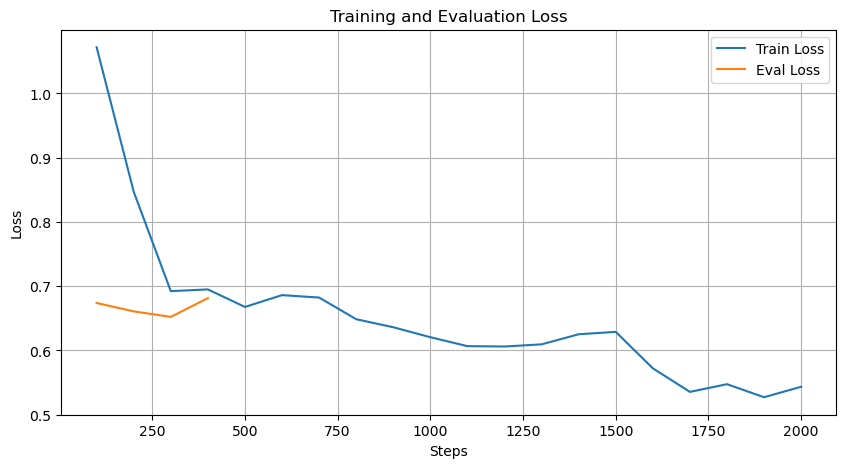

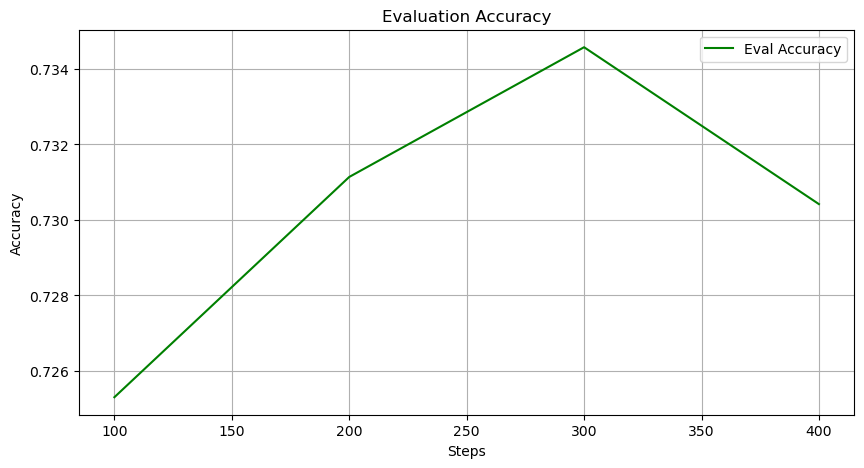

In [61]:
import json
import matplotlib.pyplot as plt

# trainer_state.json 경로
trainer_state_path = "./best_model/checkpoint-2000/trainer_state.json"

# JSON 파일 로드
with open(trainer_state_path, "r", encoding="utf-8") as f:
    trainer_state = json.load(f)

# 로그 내역 추출
logs = trainer_state["log_history"]

# 값 저장용 리스트
steps, train_loss, eval_loss, eval_accuracy = [], [], [], []

# 로그 순회
for entry in logs:
    if "loss" in entry and "step" in entry:
        steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])

# 🔹 1. Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 2. Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(steps[:len(eval_accuracy)], eval_accuracy, label="Eval Accuracy", color="green")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
